**novelty detection**:
The training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

**outlier detection**:
The training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

In [277]:
!source activate py2

In [278]:
#!/anaconda3/envs/py2/bin/pip install cvxopt

In [279]:
import numpy as np
from cvxopt import solvers, lapack, matrix, spmatrix
solvers.options['show_progress'] = 0
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline

## Generate Data

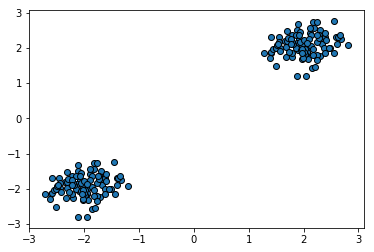

In [349]:
X = 0.3 * np.random.randn(100, 2)
X = np.r_[X + 2, X - 2]

def plot(X):
    plt.scatter(X[:,0], X[:,1], edgecolors  = 'black')
    pass

plot(X)


## Algorithms

### Basic solution : solving the dual by Quadratic Programming

\begin{aligned}
& \min_\alpha \frac{1}{2} \sum_{i,j} \alpha_i\alpha_j k(x_i,x_j) \\
& s.t. \ 0 \leq \alpha_i \leq \frac{1}{n \nu}, \ \sum_i \alpha_i = 1
\end{aligned}
In matrix form : 
\begin{aligned}
& \min_\alpha \frac{1}{2} \alpha^\top K \alpha \\ & s.t. \ 0 \leq \alpha \leq \frac{1}{n\nu}, \ 1^\top \alpha = 1
\end{aligned}

QP in standard form :

\begin{aligned}
& \min_x \frac{1}{2} x^\top P x + q^\top x \\
& s.t. \ Gx \leq h, \ Ax = b
\end{aligned}

In [350]:
a = np.random.randint(0,9, (2,2))
np.concatenate([a,a], axis = 0)

array([[4, 8],
       [1, 6],
       [4, 8],
       [1, 6]])

In [351]:
def RBF_Kernel(X, sigma2, Y = None):
    " Compute the RBF kernel matrix of X"
    from sklearn.metrics.pairwise import euclidean_distances
    
    if type(Y)==type(None):
        Y = X
    
    K = euclidean_distances(X,Y, squared=True)
    K *= -1./sigma2
    K = np.exp(K)
    return K

In [352]:
def fit(X, nu, sigma2):
    n = X.shape[0]
    K = RBF_Kernel(X, sigma2)
    
    P = matrix(K, tc = 'd')
    q = matrix([0]*n, tc = 'd')
    G = matrix(np.concatenate([np.eye(n),-np.eye(n)], axis = 0), tc = 'd')
    h_value = [1./(n * nu)]*n
    h_value.extend([0]*n)
    h = matrix(h_value, tc = 'd')
    A = matrix(np.reshape([1]*n, (1,n)), tc = 'd')
    b = matrix(1, tc = 'd')
    
    sol = solvers.qp(P,q,G,h,A,b)
    alpha = np.array(sol['x'])
    ix_in = np.where((alpha > 1e-5) & (alpha < 1./(n*nu)))[0][0]
    rho = np.transpose(np.dot(np.reshape(alpha, (1,n)), K[:,ix_in]))

    return alpha, rho

def predict(X, newData, alpha, rho, sigma2):
    n = X.shape[0]
    K = RBF_Kernel(X, sigma2, newData)
    return np.transpose(np.dot(np.reshape(alpha, (1,n)), K) - rho)

In [353]:
def get_grid(X):
    x_axis = np.arange(min(X[:,0])-0.1,max(X[:,0])+0.2,0.1)
    y_axis = np.arange(min(X[:,1])-0.1,max(X[:,1])+0.2,0.1)

    my_grid = []
    for i in x_axis:
        for j in y_axis:
            my_grid.append([i,j])#,1])
    my_grid = np.array(my_grid)
    
    return x_axis, y_axis, my_grid

def Normalize_Pred(pred):    
    pred_100 = pred -np.min(pred)
    pred_100 = (pred_100 / np.max(pred_100)) * 100
    return pred_100

def get_delim(pred_100, x_axis, y_axis, eps = 0.1):
    ix_delim = np.where((pred_100  < 50+eps) & (pred_100  > 50-eps))[0]
    x_delim = []
    y_delim = []
    for i in range(len(ix_delim)):
        a, b = np.divmod(ix_delim[i],len(y_axis))
        x_delim.append(x_axis[a])
        y_delim.append(y_axis[b])
    return x_delim, y_delim

def plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim):
    norm_colors = mpl.colors.Normalize(vmin=0,vmax=100)
    X_axis, Y_axis = np.meshgrid(x_axis, y_axis)
    C = np.transpose(pred_100.reshape((len(x_axis), len(y_axis))))
    plt.pcolor(X_axis, Y_axis, C, norm= norm_colors, cmap = 'YlOrRd')
    plt.scatter(x_delim, y_delim, c = 'black', s = 0.3)
    plot(X)
    plt.xlim((min(X[:,0])-0.1,max(X[:,0])+0.1))
    plt.ylim((min(X[:,1])-0.1,max(X[:,1])+0.1))
    pass

def plot_pred_plan(X, alpha, rho, sigma2, eps = 0.1):
    x_axis, y_axis, my_grid = get_grid(X)
    pred = predict(X, my_grid, alpha, rho, sigma2)
    pred_100 = Normalize_Pred(pred)
    x_delim, y_delim = get_delim(pred_100, x_axis, y_axis, eps)
    plot_pred(X, x_axis, y_axis, pred_100, x_delim, y_delim)
    pass

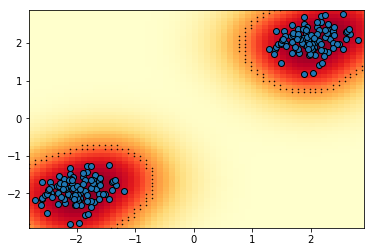

In [354]:
nu = 0.0001
sigma2 = 1

alpha, rho = fit(X, nu, sigma2)

plot_pred_plan(X, alpha, rho, sigma2, eps = 5)

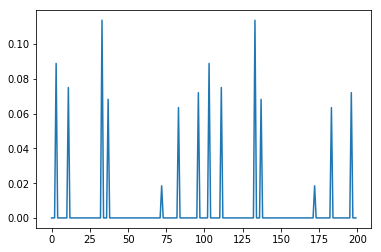

In [355]:
plt.plot(alpha)

### Better solution : SMO variant